### PS-11 Intel Products Sentiment Analysis from Online Reviews

##### Team Name: Fractals
##### Members: Aviral Srivastava, Garv Bhaskar, Dinesh Kumar
##### Institution: Vellore Institute of Technology, Chennai

### Table of Contents
* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)
* #### [Part 7. Summary Generation](#part7)
* #### [Part 8. Predictions](#part8)




In [3]:
import os

amazon_dir = './amazon'
os.chdir(amazon_dir)


In [ ]:
!scrapy crawl amaze
#Will take time to run and make the dataset data.csv

In [5]:

os.chdir('..')

---
<a id="part1"></a>
## Part 1. Data Exploration

In [6]:
import pandas as pd
import numpy as np
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.tokenize import PunktSentenceTokenizer  

import logging
import langdetect

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras.layers import Conv1D  # Use Conv1D instead of Convolution1D
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow import keras
from keras import regularizers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


C:\Users\garvb\AppData\Local\Temp\ipykernel_19552\2790854797.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load Data

In [7]:
# Load csv file
df = pd.read_csv('./amazon/data.csv')
df.head(4)

,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz Processor - Socket H2 LGA 1155 Socket OEM Pack - 512 KB - 3 MB Cache - 5 GT/,Unnamed: 1,1.0,Reviewed in India on 6 September 2023,Biplob Barman,Horrible product. Total waste of money. Don't buy it...
0,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,NaN,5.0,Reviewed in India on 22 February 2023,Faisal M.A,value for moneu iam now rating and witing revi...
1,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,NaN,4.0,Reviewed in India on 6 April 2023,Irfan shaandaar,Good condition supports all graphics and worki...
2,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,NaN,4.0,Reviewed in India on 31 March 2023,Sonu S.,Nice
3,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,NaN,2.0,Reviewed in India on 19 October 2022,NIRUPAM,"Failed processors are given, though it works."


In [8]:
df = df.drop(columns=["Unnamed: 1"])
df.head()

,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz Processor - Socket H2 LGA 1155 Socket OEM Pack - 512 KB - 3 MB Cache - 5 GT/,1.0,Reviewed in India on 6 September 2023,Biplob Barman,Horrible product. Total waste of money. Don't buy it...
0,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,5.0,Reviewed in India on 22 February 2023,Faisal M.A,value for moneu iam now rating and witing revi...
1,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,4.0,Reviewed in India on 6 April 2023,Irfan shaandaar,Good condition supports all graphics and worki...
2,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,4.0,Reviewed in India on 31 March 2023,Sonu S.,Nice
3,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,2.0,Reviewed in India on 19 October 2022,NIRUPAM,"Failed processors are given, though it works."
4,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,1.0,Reviewed in India on 25 May 2023,Anshul,The problem is start when you switch your old ...


In [9]:
df.columns = ["Product", "Rating", "Demographic", "Reviewer", "Comments"]
df

,Product,Rating,Demographic,Reviewer,Comments
0,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,5.0,Reviewed in India on 22 February 2023,Faisal M.A,value for moneu iam now rating and witing revi...
1,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,4.0,Reviewed in India on 6 April 2023,Irfan shaandaar,Good condition supports all graphics and worki...
2,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,4.0,Reviewed in India on 31 March 2023,Sonu S.,Nice
3,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,2.0,Reviewed in India on 19 October 2022,NIRUPAM,"Failed processors are given, though it works."
4,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,1.0,Reviewed in India on 25 May 2023,Anshul,The problem is start when you switch your old ...
...,...,...,...,...,...
57310,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",1.0,Reviewed in India on 7 June 2024,Amazon Customer,NaN
57311,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",3.0,Reviewed in India on 17 June 2024,Sd,Key pad is not up to the mark. Software loded ...
57312,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",5.0,Reviewed in India on 14 May 2024,Niraj kumar,"I am using this laptop for coding , laptop wor..."
57313,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",4.0,Reviewed in India on 5 June 2024,premkumar,Good.. may be mouse can be given as addon


In [10]:
df[['Location', 'Date']] = df['Demographic'].str.extract(r'Reviewed in (.*?) on (.*)')

df = df.drop(columns=["Demographic", "Reviewer"])

df.columns = ["Product", "Rating", "Reviews", "Location", "Date"]
df

,Product,Rating,Reviews,Location,Date
0,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,5.0,value for moneu iam now rating and witing revi...,India,22 February 2023
1,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,4.0,Good condition supports all graphics and worki...,India,6 April 2023
2,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,4.0,Nice,India,31 March 2023
3,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,2.0,"Failed processors are given, though it works.",India,19 October 2022
4,Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 ...,1.0,The problem is start when you switch your old ...,India,25 May 2023
...,...,...,...,...,...
57310,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",1.0,NaN,India,7 June 2024
57311,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",3.0,Key pad is not up to the mark. Software loded ...,India,17 June 2024
57312,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",5.0,"I am using this laptop for coding , laptop wor...",India,14 May 2024
57313,"HP Laptop 15,12th Gen Intel Core i3-1215U,15.6...",4.0,Good.. may be mouse can be given as addon,India,5 June 2024


In [11]:
distinct_values = df["Product"].unique()

print("Distinct values in Column1:")
for value in distinct_values:
    print(value)

Distinct values in Column1:
Intel Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz Processor - Socket H2 LGA 1155 Socket OEM Pack - 512 KB - 3 MB Cache - 5 GT/
Intel Core i3-10105F LGA1200 Desktop Processor 4 Cores 8 Threads up to 4.40GHz 6MB Cache
Intel Core I5-13400 Processor 20M Cache, Up to 4.60 Ghz, LGA 1700
Lenovo IdeaPad Slim 3 Intel Core i3 12th Gen 15.6" (39.62cm) FHD Thin & Light Laptop (8GB/512GB SSD/Windows 11/Office 2021/1Yr ADP Free/3months Game Pass/Arctic Grey/1.63Kg), 82RK00VTIN
ASUS TUF Gaming F17 - Gaming Laptop, Intel Core i5-11260H 11th Gen, 17.3-inch (43.94 cm) FHD 144Hz, (8GB/512GB SSD/4GB NVIDIA RTX 2050/Win 11/ RGB Backlit/Black/2.60 kg),FX706HF-HX044WS
ASUS Vivobook 15 (2023), Intel Core I5-13500H 13Th Gen, 15.6" (39.62 Cms) Fhd, Thin and Light Laptop (16Gb/512Gb Ssd/Intel Iris X?/Win 11/Office 2021/Backlit Kb/Blue/1.7 Kg), X1502Va-Nj541Ws
Acer Aspire 12th Gen Intel Core i3-12100 Processor Desktop (Windows 11 Home/8 GB RAM/512 GB SATA SSD/MS Office) with Standard W

In [13]:
def extract_info(row):
    # Split the text by spaces
    parts = row.split()
    # Extract relevant information
    brand = parts[0]
    try:
        # Extracting model till 'Processor' for processors
        if 'Processor' in row:
            model = ' '.join(parts[1:parts.index('Processor')])
        else:
            model = 'N/A'
    except ValueError:
        # If the keyword is not found, set model as N/A
        model = 'N/A'
    return pd.Series([brand, model])

# Apply the function to the DataFrame and concatenate the results
df[['Brand', 'Model']] = df['Product'].apply(extract_info)

# Drop the original column
df.drop('Product', axis=1, inplace=True)

# Display the resulting DataFrame
print(df)

       Rating                                            Reviews Location  \
0         5.0  value for moneu iam now rating and witing revi...    India   
1         4.0  Good condition supports all graphics and worki...    India   
2         4.0                                               Nice    India   
3         2.0      Failed processors are given, though it works.    India   
4         1.0  The problem is start when you switch your old ...    India   
...       ...                                                ...      ...   
57310     1.0                                                NaN    India   
57311     3.0  Key pad is not up to the mark. Software loded ...    India   
57312     5.0  I am using this laptop for coding , laptop wor...    India   
57313     4.0         Good..  may be mouse can be given as addon    India   
57314     4.0  Just bought hp 15 i3 1315 laptop no intel iris...    India   

                   Date  Brand                                        Model

In [14]:
# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Standardize the Brand column
df['Brand'] = df['Brand'].str.replace('Intel®', 'Intel', regex=False)
df['Brand'] = df['Brand'].str.replace('INTEL', 'Intel', regex=False)

# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Remove rows where Brand doesn't come under Intel
df = df[df['Brand'] == 'Intel']

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df

C:\Users\garvb\AppData\Local\Temp\ipykernel_19552\1754357483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brand'] = df['Brand'].str.replace('Intel®', 'Intel', regex=False)
C:\Users\garvb\AppData\Local\Temp\ipykernel_19552\1754357483.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brand'] = df['Brand'].str.replace('INTEL', 'Intel', regex=False)


,Rating,Reviews,Location,Date,Brand,Model
0,5.0,value for moneu iam now rating and witing revi...,India,22 February 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz
1,4.0,Good condition supports all graphics and worki...,India,6 April 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz
2,4.0,Nice,India,31 March 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz
3,2.0,"Failed processors are given, though it works.",India,19 October 2022,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz
4,1.0,The problem is start when you switch your old ...,India,25 May 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz
...,...,...,...,...,...,...
27467,5.0,I use davinci and blender and render vids and ...,the United States,16 May 2022,Intel,X-Series Desktop
27468,5.0,Awesome processor. Running 4.8ghz all core rig...,the United States,6 March 2020,Intel,X-Series Desktop
27469,1.0,I tried 2 different CPU 2 brand new Motherboa...,the United States,4 March 2021,Intel,X-Series Desktop
27470,5.0,Worked as described.,the United States,23 March 2021,Intel,X-Series Desktop


In [15]:
# Function to extract Core series (i3, i5, i7, i9)
def extract_core_series(model):
    match = re.search(r'i[3579]', model)
    return match.group() if match else 'N/A'

# Function to extract generation
def extract_generation(model):
    match = re.search(r'i[3579]-(\d{4})|i[3579] (\d{4})', model)
    if match:
        return int(match.group(1) or match.group(2)) // 100
    return 'N/A'

# Apply the functions to create new columns using .loc
df.loc[:, 'Core_Series'] = df['Model'].apply(extract_core_series)
df.loc[:, 'Generation'] = df['Model'].apply(extract_generation)

# Remove rows where Core_Series or Generation is 'N/A'
df = df[(df['Core_Series'] != 'N/A') & (df['Generation'] != 'N/A')]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df


,Rating,Reviews,Location,Date,Brand,Model,Core_Series,Generation
0,5.0,value for moneu iam now rating and witing revi...,India,22 February 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,i3,21
1,4.0,Good condition supports all graphics and worki...,India,6 April 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,i3,21
2,4.0,Nice,India,31 March 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,i3,21
3,2.0,"Failed processors are given, though it works.",India,19 October 2022,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,i3,21
4,1.0,The problem is start when you switch your old ...,India,25 May 2023,Intel,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,i3,21
...,...,...,...,...,...,...,...,...
21018,5.0,Le recomiendo mucho de comprar este producto d...,the United States,23 June 2024,Intel,Core i5-11600KF Desktop,i5,11
21019,3.0,"It feels like a refurbished cpu, 67C under 3-f...",Canada,16 November 2023,Intel,Core i5-11600KF Desktop,i5,11
21020,5.0,I've been using this CPU for a couple months n...,the United States,11 December 2022,Intel,Core i5-11600KF Desktop,i5,11
21021,5.0,With a good flowing case and a good cooler thi...,the United States,14 June 2023,Intel,Core i5-11600KF Desktop,i5,11


In [16]:
# Rearrange the columns
df = df[['Brand', 'Core_Series', 'Generation','Model', 'Rating', 'Date', 'Location','Reviews']]
df

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews
0,Intel,i3,21,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,5.0,22 February 2023,India,value for moneu iam now rating and witing revi...
1,Intel,i3,21,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,4.0,6 April 2023,India,Good condition supports all graphics and worki...
2,Intel,i3,21,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,4.0,31 March 2023,India,Nice
3,Intel,i3,21,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,2.0,19 October 2022,India,"Failed processors are given, though it works."
4,Intel,i3,21,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,1.0,25 May 2023,India,The problem is start when you switch your old ...
...,...,...,...,...,...,...,...,...
21018,Intel,i5,11,Core i5-11600KF Desktop,5.0,23 June 2024,the United States,Le recomiendo mucho de comprar este producto d...
21019,Intel,i5,11,Core i5-11600KF Desktop,3.0,16 November 2023,Canada,"It feels like a refurbished cpu, 67C under 3-f..."
21020,Intel,i5,11,Core i5-11600KF Desktop,5.0,11 December 2022,the United States,I've been using this CPU for a couple months n...
21021,Intel,i5,11,Core i5-11600KF Desktop,5.0,14 June 2023,the United States,With a good flowing case and a good cooler thi...


In [17]:
distinct_values = df["Model"].unique()

print("Distinct Processors being evaluated:")
for value in distinct_values:
    print(value)

Distinct Processors being evaluated:
Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz
Core i3-10105F LGA1200 Desktop
Core i7 12700F 12 Gen Desktop PC
Core i5-11400F Desktop
Core i3-10100
Core i5-12400 Desktop
Core i7 12700 12th Gen Generation Desktop PC
Core i5 12600K 12 Gen Generation Desktop PC
Core i5-2400
Core i7-11700 Desktop
Core i9-11900K Desktop
Core i5-12600K Desktop
Core i7-12700K Desktop
Core™ i7-13700F
Core i3-12100
Core i3-10100F 10th Generation LGA1200 Desktop
Core i7-14700F Desktop
Core i3 12100F 12th Gen Generation Desktop PC
Core i5-10400F 10th Generation
Core i5-10400
Core i5-11400 Desktop
Core i5-3470 Ivy Bridge 3.2GHz 5.0GT s 6MB LGA 1155 CPU OEM
Core i7-13700K Desktop
Core i5-11500 Desktop
Core i7-11700K LGA1200 Desktop
CoreTM i5-14600K LGA 1700 Socket New Gaming Desktop
Core i3-9100F 9th Gen Desktop
Core i9-11900 LGA1200 Desktop
Core i7 9700 Desktop 9th Gen
Core™ i9-13900KF
Core i3-9350KF Desktop
Core i3-10100F
Core i5-11600KF Desktop


### Data Exploration

In [18]:
# Summary statistics of numerical features
print("Summary statistics of numerical features:\n", df.describe())

# Total number of reviews
total_reviews = len(df)
print("\nTotal number of reviews:", total_reviews)

# Total number of unique products
unique_products = len(df['Model'].unique())
print("\nTotal number of unique products:", unique_products)

# Percentage of reviews with neutral sentiment
neutral_percentage = (df[df['Rating'] == 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with neutral sentiment: {:.2f}%".format(neutral_percentage))

# Percentage of reviews with positive sentiment
positive_percentage = (df[df['Rating'] > 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with positive sentiment: {:.2f}%".format(positive_percentage))

# Percentage of reviews with negative sentiment
negative_percentage = (df[df['Rating'] < 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with negative sentiment: {:.2f}%".format(negative_percentage))


Summary statistics of numerical features:
              Rating
count  21023.000000
mean       4.197260
std        1.374693
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

Total number of reviews: 21023

Total number of unique products: 33

Percentage of reviews with neutral sentiment: 5.40%

Percentage of reviews with positive sentiment: 79.06%

Percentage of reviews with negative sentiment: 14.21%


### Data Visualization 

Text(0, 0.5, 'Count')

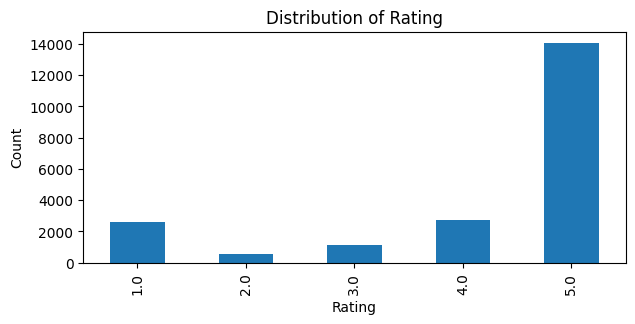

In [19]:
# Plot distribution of rating
plt.figure(figsize=(7,3))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 10 Highest-Reviewed Processors')

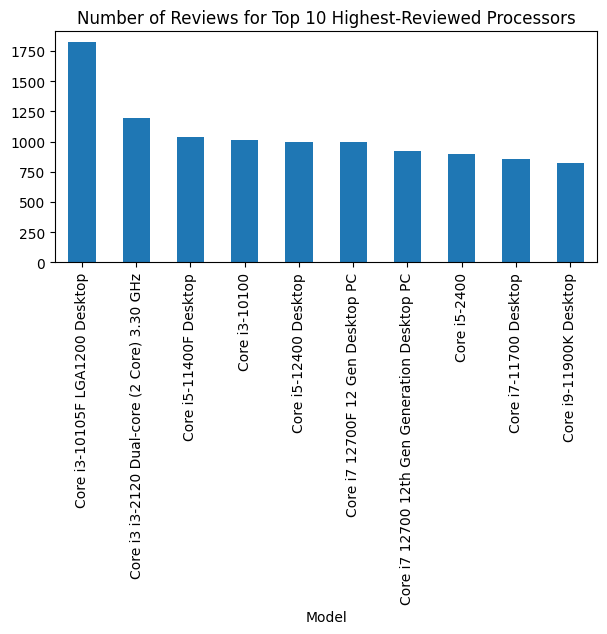

In [20]:
# Plot number of reviews for top 10
brands = df["Model"].value_counts()
# brands.count()
plt.figure(figsize=(7,3))
brands[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 10 Highest-Reviewed Processors")

Text(0, 0.5, 'Count')

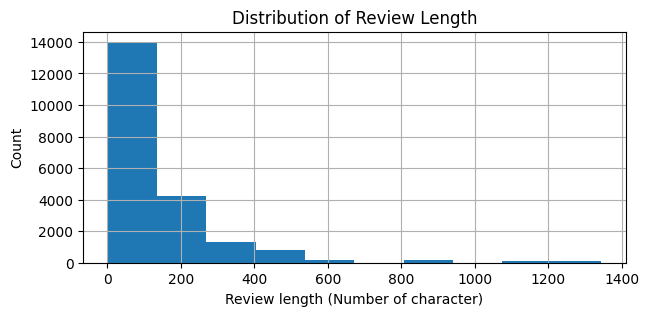

In [21]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(7,3))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

C:\Users\garvb\AppData\Local\Temp\ipykernel_19552\1577005283.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Core_Series', y='Rating', palette='Set2', ax=axs[0, 1])
C:\Users\garvb\AppData\Local\Temp\ipykernel_19552\1577005283.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Generation', y='Rating', palette='Set2', ax=axs[1, 0])


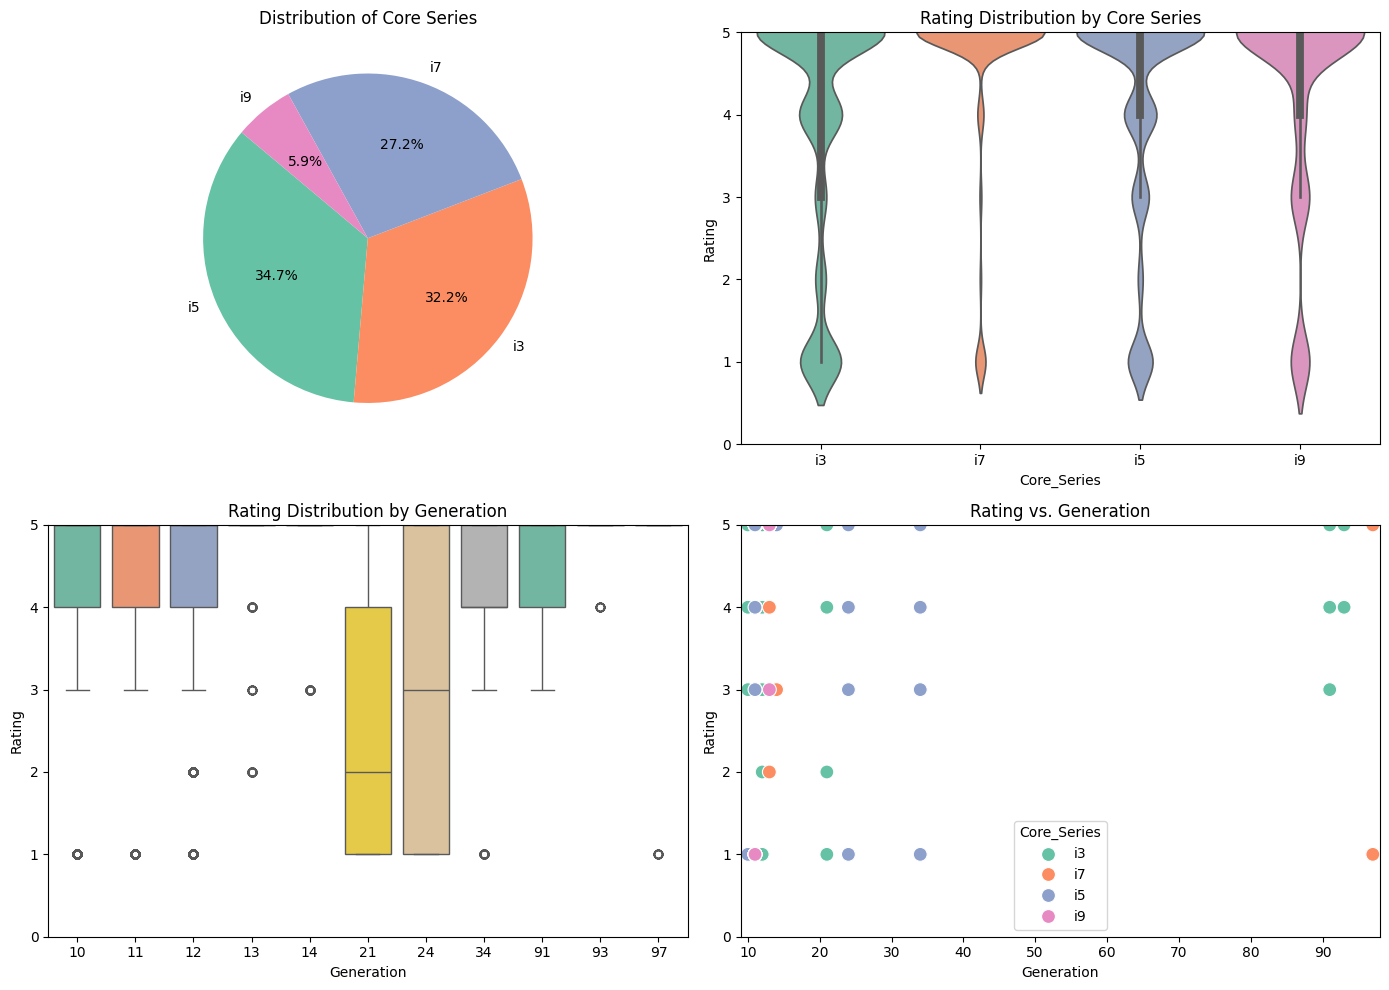

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Pie chart of Core Series distribution
core_series_counts = df['Core_Series'].value_counts()
axs[0, 0].pie(core_series_counts, labels=core_series_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
axs[0, 0].set_title('Distribution of Core Series')

# Plot 2: Violin plot of Ratings by Core Series
sns.violinplot(data=df, x='Core_Series', y='Rating', palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title('Rating Distribution by Core Series')
axs[0, 1].set_ylim(0, 5)

# Plot 3: Box plot of Ratings by Generation
sns.boxplot(data=df, x='Generation', y='Rating', palette='Set2', ax=axs[1, 0])
axs[1, 0].set_title('Rating Distribution by Generation')
axs[1, 0].set_ylim(0, 5)

# Plot 4: Scatter plot of Rating vs. Generation
sns.scatterplot(data=df, x='Generation', y='Rating', hue='Core_Series', palette='Set2', s=100, ax=axs[1, 1])
axs[1, 1].set_title('Rating vs. Generation')
axs[1, 1].set_ylim(0, 5)
axs[1, 1].set_xlim(df['Generation'].min() - 1, df['Generation'].max() + 1)

plt.tight_layout()
plt.show()

---
<a id="part2"></a>
## Part 2. Data Preparation

For illustrative purpose, I use only 10% of the data in this project. To simply the problem, I only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [23]:
df = df.sample(frac=1, random_state=71) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

#Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head(40)

,Brand,Core_Series,Generation,Model,Rating,Date,Location,Reviews,Sentiment
1444,Intel,i3,10,Core i3-10100,5.0,24 May 2021,India,Compare 7-8 gen i7... 4 cores 8 threads just w...,1
1206,Intel,i5,12,Core i5-12400 Desktop,5.0,25 October 2023,India,Super,1
8515,Intel,i7,12,Core i7-12700K Desktop,5.0,23 August 2023,Spain,Es lo que se espera de sus especificaciones.,1
6728,Intel,i7,11,Core i7-11700 Desktop,5.0,3 February 2024,the United States,I bought this i7-11700 CPU because it was bein...,1
12261,Intel,i7,11,Core i7-11700K LGA1200 Desktop,4.0,30 December 2021,Germany,Zufrieden 👌,1
2908,Intel,i5,24,Core i5-2400,5.0,23 June 2023,India,I am happy.,1
1019,Intel,i3,21,Core i3 i3-2120 Dual-core (2 Core) 3.30 GHz,1.0,18 June 2023,India,If you are lookin this cpu for gaming Don't bu...,0
13534,Intel,i7,13,Core i7-13700K Desktop,5.0,28 March 2023,India,Most powerful cpu at this price bracket no dou...,1
9011,Intel,i3,12,Core i3 12100F 12th Gen Generation Desktop PC,1.0,20 June 2023,India,The Processor is Good & Works Fine. But The De...,0
15302,Intel,i7,97,Core i7 9700 Desktop 9th Gen,5.0,7 September 2020,Canada,this thing is in beast mode all the time baby....,1


In [ ]:
def is_english(text):
  """Checks if the text is in English using langdetect"""
  try:
    return langdetect.detect(text) == 'en'
  except langdetect.LangDetectException:  # Handle potential errors
    return False

# Drop rows with missing reviews or non-English reviews
df = df[df['Reviews'].notnull() & df['Reviews'].apply(is_english)]

df.head(5)

In [ ]:
df.shape

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d %B %Y')

# Plot sentiment trends over time
plt.figure(figsize=(7, 3))
df.groupby(df['Date'].dt.to_period('M'))['Sentiment'].mean().plot(kind='line')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()

In [ ]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group data by date and sentiment, count occurrences, and unstack the result
sentiment_trend = df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trends over time
sentiment_trend.plot(kind='line', figsize=(7, 4))

# Add title and labels
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')

# Show plot
plt.show()


In [ ]:
location_sentiment_count = df.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment counts for each location
location_sentiment_count.plot(kind='bar', stacked=True, figsize=(7, 3))

# Add title and labels
plt.title('Sentiment Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Number of Reviews')

# Show legend
plt.legend(title='Sentiment')

# Show plot
plt.show()

In [ ]:
import seaborn as sns

# Select columns for the heatmap
columns = ['Rating', 'Sentiment']

# Compute the correlation matrix
correlation_matrix = df[columns].corr()

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Now we remove Brand column as it is redundant
df.drop(columns=['Brand'], inplace=True)
df

### Train Test Split 

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df["Reviews"], df["Sentiment"],
                                                   test_size=0.35, random_state=50)

print('Loaded %d training examples and %d validation examples.\n' % (X_train.shape[0], X_test.shape[0]))

# Print a sample review from the training set
print('Sample review in the training set:\n', X_train.iloc[0])  # Use iloc to access by positional index

# Example of iterating through first few reviews in training set
print('\nFirst few reviews in the training set:')
for i in range(5):
    print(f'Review {i+1}: {X_train.iloc[i]}')

In [ ]:

# Load your data (df["Reviews"] and df["Sentiment"])

# Define the undersampling method (RandomUnderSampler)
rus = RandomUnderSampler(random_state=50)

# Undersample while preserving data types (using Series.to_frame)
X_resampled_df = pd.DataFrame(df["Reviews"].values.reshape(-1, 1), columns=["Reviews"])
y_resampled_df = pd.Series(df["Sentiment"])
X_resampled, y_resampled = rus.fit_resample(X_resampled_df, y_resampled_df)

# Convert back to pandas Series after undersampling (assuming text in "Reviews")
X_resampled = pd.Series(X_resampled.squeeze())  # Assuming text data in first column

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.35, random_state=50)

# Print class distribution after undersampling
print('Class distribution after undersampling:')
print(y_train.value_counts())  # Print counts for each sentiment class

print('Loaded %d training examples and %d validation examples.\n' % (X_train.shape[0], X_test.shape[0]))

---
<a id="part3"></a>
## Part 3. Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

### Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [ ]:
from bs4 import BeautifulSoup
import numpy as np

# Assuming X_train and X_test are lists of text data
# Define a function to clean text data

# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n')
for i in range(5):
    print(X_train_cleaned[i])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm. 

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" % len(countVect.get_feature_names_out())) #6378 
print("Show some feature names : \n", countVect.get_feature_names_out()[1::1000])

# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)


In [ ]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [ ]:
# Evaluate the model on validaton set
X_test_features = countVect.transform(X_test_cleaned) 
predictions = mnb.predict(X_test_features)
modelEvaluation(predictions)

### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. 

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [ ]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out())) #1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[1::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

In [ ]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [ ]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)

### Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [ ]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.2, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 10], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

---
<a id="part4"></a>
## Part 4. Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer
import nltk
nltk.download('punkt')

# Define the tokenizer
tokenizer = PunktSentenceTokenizer()

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(word_tokenize(cleanText(raw_sentence, remove_stopwords)))
    return sentences

# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)

print('%d parsed sentences in the training set\n' % len(sentences))
print("Some parsed sentences from the training set:")
for i in range(5):  # Adjust the range as needed
    print(f"Sentence {i+1}: {sentences[i]}")



### Creating Volcabulary List using Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word vector representations by sepcifiying the embedding dimension (= length of feature vector).

In [ ]:
import logging
import re
from gensim.models import Word2Vec

# Enable logging for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300  # Embedding dimension
min_word_count = 10  # Minimum word count
num_workers = 4  # Number of threads to run in parallel
context = 10  # Context window size
downsampling = 1e-3  # Downsample setting for frequent words
epochs = 3  # Number of epochs

print("Training Word2Vec model ...\n")

# Assume `sentences` is your list of tokenized sentences
w2v = Word2Vec(sentences=sentences,vector_size=num_features, min_count=min_word_count, workers=num_workers,
               window=context, sample=downsampling)

w2v.build_vocab(sentences)

# Train the model
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=epochs)

# To make the model memory-efficient
w2v.init_sims(replace=True)

# Save the model
w2v.save("w2v_300features_10minwordcounts_10context")

# Access vocabulary information (avoiding deprecated 'vocab' attribute)
all_words = list(w2v.wv.key_to_index.keys())  # Get all words using key_to_index

# Remove punctuation and other symbols
cleaned_vocabulary = [word for word in all_words if re.match(r'^\w+$', word)]

print("Number of words in the cleaned vocabulary list: %d \n" % len(cleaned_vocabulary))
print("Show words in the cleaned vocabulary list: \n", cleaned_vocabulary)


### Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [ ]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
  """
  Transforms a review into a feature vector by averaging word vectors.

  Args:
      review (list): List of words in the review.
      model (gensim.models.Word2Vec): The trained Word2Vec model.
      num_features (int): Dimensionality of the word vectors.

  Returns:
      numpy.ndarray: Feature vector representing the review (shape: (num_features,)).
  """

  feature_vec = np.zeros((num_features,), dtype="float32")
  word_count = 0

  # Iterate through words in the review, checking for existence and adding vectors
  for word in review:
    if word in model.wv.key_to_index:  # Check if word exists in vocabulary
      word_count += 1
      feature_vec = np.add(feature_vec, model.wv[word])  # Use model.wv for word vectors

  # Handle cases with no words in vocabulary (return zero vector)
  if word_count == 0:
    return feature_vec

  # Average the feature vector (divide by word count)
  return np.divide(feature_vec, word_count)


def getAvgFeatureVecs(reviews, model, num_features):
  """
  Transforms all reviews in a list into feature vectors using makeFeatureVec.

  Args:
      reviews (list): List of reviews (each review is a list of words).
      model (gensim.models.Word2Vec): The trained Word2Vec model.
      num_features (int): Dimensionality of the word vectors.

  Returns:
      numpy.ndarray: Feature vectors for all reviews (shape: (len(reviews), num_features)).
  """

  review_feature_vecs = np.zeros((len(reviews), num_features), dtype="float32")
  for i, review in enumerate(reviews):
    review_feature_vecs[i] = makeFeatureVec(review, model, num_features)

  return review_feature_vecs

In [ ]:
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" % trainVector.shape)

# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" % testVector.shape)

### Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=7)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)

In [ ]:
# Feature importance based on RandomForestClassifier
feature_importance = rf.feature_importances_

# Get feature names (assuming df is a pandas DataFrame)
feature_names = df.columns

# Sort feature importance in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

# Print feature importance ranking
print("Feature importance ranking:")
for i in sorted_idx:
    if i < len(feature_names):  # Ensure index is within bounds
        print(f"{feature_names[i]}: {feature_importance[i]}")

---
<a id="part5"></a>
## Part 5. LSTM



Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

### Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train_cleaned)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

In [ ]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(Dropout(0.3))
model1.add(LSTM(64))
model1.add(Dropout(0.35))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

In [ ]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[4].get_weights()[0].shape) #(128, 2) weight dim of dense layer

### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [ ]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

In [ ]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train_cleaned)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train_cleaned shape:', X_train_seq.shape) #(27799, 100)
print('X_test_cleaned shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

In [ ]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Dropout(0.3))
model2.add(LSTM(64))
model2.add(Dropout(0.35))
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

In [ ]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[4].get_weights()[0].shape) #(128, 2) weight dim of dense layer

---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [ ]:
predictions = model2.predict(X_test_seq)  # Get probabilities for each sentiment class
predictions = np.argmax(predictions, axis=-1) 
# Initialize empty lists for positive and negative words
positive_words = []
negative_words = []

# Loop through reviews, predictions, and pre-trained embeddings (assuming you have them)
for review, sentiment, embedding in zip(df["Reviews"], predictions, X_test_seq):
  words = review.split()  # Split review into words
  embedding_list = embedding.tolist()  # Assuming embedding is a numpy array

  # Filter words based on predicted sentiment and embedding existence
  for word, word_embedding in zip(words, embedding_list):
    if word_embedding is not None:  # Check if embedding exists (optional)
      if sentiment == 1:  # Positive sentiment
        if word not in positive_words:  # Add unique words to list
          positive_words.append(word)
      else:  # Negative sentiment
        negative_words.append(word)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=600).generate(" ".join(positive_words))
negative_wordcloud = WordCloud(width=800, height=600).generate(" ".join(negative_words))

# Display or save word clouds
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(positive_wordcloud)
plt.title('Positive Words')
plt.axis("off")

plt.subplot(122)
plt.imshow(negative_wordcloud)
plt.title('Negative Words')
plt.axis("off")

plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK stopwords and part-of-speech tagger
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def is_adjective(word):
    """Check if a word is an adjective."""
    return pos_tag([word])[0][1] == 'JJ'

def is_meaningful(word):
    """Check if a word is a meaningful non-adjective."""
    pos_tagged = pos_tag([word])[0][1]
    # Include only nouns, verbs, and adverbs
    return pos_tagged.startswith('N') or pos_tagged.startswith('V') or pos_tagged == 'RB'

# Extend stopwords with common non-characteristic words
additional_stopwords = {'cpu', 'processor', 'monitor', 'pc', 'computer', 'intel', 'core', 'generation', 'desktop', 'gen', 'i5', 'i7', 'i9', 'pentium'}
stop_words = set(stopwords.words('english')).union(additional_stopwords)

def create_word_cloud_with_top_words(sentiment, adjectives_only=True):
    df_sample = df[df['Sentiment'] == sentiment]
    df_sample = df_sample.sample(frac=0.1, random_state=0)
    
    word_cloud_collection = ''
    
    for val in df_sample['Reviews'].str.lower():
        tokens = nltk.word_tokenize(val)
        if adjectives_only:
            tokens = [word for word in tokens if word.isalpha() and word not in stop_words and is_adjective(word)]
        else:
            tokens = [word for word in tokens if word.isalpha() and word not in stop_words and is_meaningful(word)]
        word_cloud_collection += ' '.join(tokens) + ' '
    
    wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    sentiment_type = 'Adjectives' if adjectives_only else 'Meaningful Non-Adjectives'
    plt.title(f'Word Cloud for {sentiment_type} - Sentiment {sentiment}')
    plt.show()
    
    # Plot top 5 words
    word_counts = Counter(word_cloud_collection.split())
    top_words = word_counts.most_common(10)
    
    words, counts = zip(*top_words)
    plt.figure(figsize=(11, 5))
    plt.bar(words, counts, color='skyblue')
    plt.title(f'Top 10 {sentiment_type} Words for Sentiment {sentiment}')
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

# Create word clouds and top words for positive (1) and negative (0) sentiments
# For Meaningful Non-Adjectives
create_word_cloud_with_top_words(1, adjectives_only=False)
create_word_cloud_with_top_words(0, adjectives_only=False)


---
<a id="part7"></a>
## Part 7. Summary Generation

In [ ]:
from transformers import pipeline

In [ ]:
# Initialize the BERT summarization pipeline with the specific model
summarizer = pipeline("summarization", model="google/flan-t5-base")

Using BERT: BERT (Bidirectional Encoder Representations from Transformers) is a powerful language model that can be used for text summarization. BERT-based models have achieved state-of-the-art results in various natural language processing tasks, including text summarization.

In [ ]:

# Get positive texts from the 'text' column in your dataset
positive_texts =  df[df['Sentiment'] == 1]['Reviews'].tolist()


# Combine all positive texts into one string
combined_text = " ".join(positive_texts)

# Split the combined text into chunks of maximum length 1024
texts = []
chunk = ""
for sentence in combined_text.split():
    if len(chunk) + len(sentence) > 1024:
        texts.append(chunk)
        chunk = ""
    chunk += sentence + " "
if chunk:
    texts.append(chunk)
summaries = []
# Generate summaries for each chunk of text
for i, text in enumerate(texts):
    if i >= 10:
        break
    print("\nSummary:")
    summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
    print(summary[0]['summary_text'])
    summaries.append(summary[0]['summary_text']) 



In [ ]:
# Combine individual summaries into a single string
combined_summaries = " ".join(summaries)

# Summarize the combined summaries
final_summary = summarizer(combined_summaries, max_length=200, min_length=50, do_sample=False)
print("\nFinal Summary:")
print(final_summary[0]['summary_text'])

In [ ]:

# Get positive texts from the 'text' column in your dataset
negative_texts = positive_texts = df[df['Sentiment'] == 0]['Reviews'].tolist()


# Combine all positive texts into one string
combined_text = " ".join(negative_texts)

# Split the combined text into chunks of maximum length 1024
texts = []
chunk = ""
for sentence in combined_text.split():
    if len(chunk) + len(sentence) > 1024:
        texts.append(chunk)
        chunk = ""
    chunk += sentence + " "
if chunk:
    texts.append(chunk)
summaries = []
# Generate summaries for each chunk of text
for i, text in enumerate(texts):
    if i >= 10:
        break
    print("\nSummary:")
    summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
    print(summary[0]['summary_text'])
    summaries.append(summary[0]['summary_text']) 



In [ ]:
# Combine individual summaries into a single string
combined_summaries = " ".join(summaries)

# Summarize the combined summaries
final_summary = summarizer(combined_summaries, max_length=200, min_length=50, do_sample=False)
print("\nFinal Summary:")
print(final_summary[0]['summary_text'])

---
<a id="part8"></a>
## Part 8. Predictions

In [ ]:
test =["Fantastic Product, Loved it", "Worst product in series", "Could have been better", "Heating issues and delivered late"]
cleaned_test = [cleanText(review) for review in test]
tokenizer = Tokenizer(num_words=top_words)  # Consider using 'num_words' instead of 'nb_words'
print(test)
# If the tokenizer wasn't fit on the entire corpus earlier:
if not tokenizer.word_index:
    tokenizer.fit_on_texts(cleaned_test)  # Fit the tokenizer on the entire corpus for better predictions

# Tokenize the cleaned test reviews
sequences_test = tokenizer.texts_to_sequences(cleaned_test)

# Pad the sequences to a fixed length (same as training data)
padded_test_sequences = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# Make predictions with both models
predictions_model1 = model1.predict(padded_test_sequences)
predictions_model2 = model2.predict(padded_test_sequences)

# Analyze and interpret the predictions based on your models' output formats
# (e.g., probabilities for multiple classes, single class predictions, etc.)
print("Predictions from Model 1:", predictions_model1)
print("Predictions from Model 2:", predictions_model2)
